In [11]:
import numpy as np
import pandas as pd
import scipy as sci
import matplotlib.pyplot as plt
import os
import altair as alt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

print("packages imported")

packages imported


## Preparations and set ups:

In [12]:
url_players='https://drive.google.com/file/d/1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz/edit'
url_players='https://drive.google.com/uc?id=' + url_players.split('/')[-2]
players = pd.read_csv(url_players)

url_sessions='https://drive.google.com/file/d/14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB/edit'
url_sessions='https://drive.google.com/uc?id=' + url_sessions.split('/')[-2]
sessions = pd.read_csv(url_sessions)

experience_mapping = {
    'Beginner': 1,
    'Amateur': 2,
    'Regular': 3,
    'Veteran': 4,
    'Pro': 5
}

sessions['start_time'] = pd.to_datetime(sessions['start_time'], format="%d/%m/%Y %H:%M")
sessions['end_time'] = pd.to_datetime(sessions['end_time'], format="%d/%m/%Y %H:%M")

sessions['session_length'] = (sessions['end_time'] - sessions['start_time']).dt.total_seconds() / 3600
sessions['original_session_length'] = (sessions['original_end_time'] - sessions['original_start_time'])

player_sessions = sessions.groupby('hashedEmail').agg(
    number_sessions=('session_length', 'size'), 
    mean_session_length=('session_length', 'mean'), 
    sd_session_length=('session_length', 'std') 
).reset_index()

players_combined = pd.merge(players, player_sessions, on='hashedEmail', how='left')
players_combined['experience_val'] = players_combined['experience'].map(experience_mapping)
players_combined['subscribe_binary'] = players_combined['subscribe'].astype(int)
players_combined = players_combined.dropna(subset=['subscribe_binary', 'experience_val', 'age', 'number_sessions', 'played_hours'])
players_combined

,experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName,number_sessions,mean_session_length,sd_session_length,experience_val,subscribe_binary
0,Pro,True,f6daba428a5e19a3d47574858c13550499be23603422e6...,30.3,Morgan,Male,9,NaN,NaN,27.0,1.246296,0.902162,5,1
1,Veteran,True,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa9397...,3.8,Christian,Male,17,NaN,NaN,3.0,1.416667,1.233671,4,1
2,Veteran,False,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3...,0.0,Blake,Male,17,NaN,NaN,1.0,0.083333,NaN,4,0
3,Amateur,True,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4f...,0.7,Flora,Female,21,NaN,NaN,1.0,0.833333,NaN,2,1
4,Regular,True,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb...,0.1,Kylie,Male,21,NaN,NaN,1.0,0.150000,NaN,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,Veteran,True,ba24bebe588a34ac546f8559850c65bc90cd9d51b82158...,0.1,Gabriela,Female,44,NaN,NaN,1.0,0.183333,NaN,4,1
192,Veteran,False,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778...,0.3,Pascal,Male,22,NaN,NaN,1.0,0.350000,NaN,4,0
193,Amateur,False,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db29...,0.0,Dylan,Prefer not to say,17,NaN,NaN,1.0,0.083333,NaN,2,0
194,Amateur,False,f19e136ddde68f365afc860c725ccff54307dedd13968e...,2.3,Harlow,Male,17,NaN,NaN,6.0,0.497222,0.733592,2,0


## Attempt for a simple linear regression using age as covariate and played_hour as responible variable:

In [13]:
players_training, players_testing = train_test_split(
   players_combined, test_size=0.3, random_state=2000 
)

X_train = players_training[["age"]]
y_train = players_training['played_hours']

X_test = players_testing[["age"]] 
y_test = players_testing['played_hours'] 


model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

intercept = model.intercept_
slope = model.coef_[0]

print("Mean Squared Error:", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r2)
print("Adjusted R-squared:", adjusted_r2)
print("Intercept:", model.intercept_)
print("Coefficient:", model.coef_)

print("Intercept (b0):", intercept)
print("Slope (b1):", slope)

Mean Squared Error: 899.8746412307555
Root Mean Squared Error (RMSE): 29.99791061442039
R-squared: -0.013314868878676167
Adjusted R-squared: -0.041462504125306054
Intercept: 16.443168705485157
Coefficient: [-0.31916523]
Intercept (b0): 16.443168705485157
Slope (b1): -0.3191652310147073


In [14]:
X_all = pd.concat([X_train, X_test], axis=0)
y_all = pd.concat([y_train, y_test], axis=0)

X_all['Actual'] = y_all
X_all['Predicted'] = model.predict(X_all[['age']])

scatter = alt.Chart(X_all.reset_index()).mark_circle(size=60).encode(
    x=alt.X('age', title='Age'),
    y=alt.Y('Actual', title='Played Hours'),
    tooltip=['age', 'Actual', 'Predicted']
).properties(
    title="Linear Regression: Played Hours vs Age (All Data)"
)

line = alt.Chart(X_all.reset_index()).mark_line(color='red', size=2).encode(
    x=alt.X('age', title='Age'),
    y=alt.Y('Predicted', title='Played Hours')
)

plot = scatter + line
plot.display()

alt.LayerChart(...)

Needless to say, this model has a negative R2 statsictis which means it performs worse than a flat line.

In [15]:
X = players_combined[['subscribe_binary', 'experience_val', 'age', 'number_sessions']]
y = players_combined['played_hours']

X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)
y_train, y_test = train_test_split(y, test_size=0.3, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

print("Mean Squared Error:", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r2)
print("Adjusted R-squared:", adjusted_r2)
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

coefficients = pd.DataFrame({
    'Feature': ['subscribe_binary', 'experience_val', 'age', 'number_sessions'],
    'Coefficient': model.coef_
})

print(coefficients)

Mean Squared Error: 43.453683282655746
Root Mean Squared Error (RMSE): 6.591940782702447
R-squared: 0.5304112973175944
Adjusted R-squared: 0.47349145456821196
Intercept: -5.221174835980367
Coefficients: [ 4.03748816  2.17606734 -0.10342626  0.64320256]
            Feature  Coefficient
0  subscribe_binary     4.037488
1    experience_val     2.176067
2               age    -0.103426
3   number_sessions     0.643203


This however, seems to be much better in terms of R_squared statsictis.

In [16]:
X1 = players_combined[['subscribe_binary', 'experience_val', 'age', 'number_sessions']]
Y1 = players_combined['played_hours']

X1 = sm.add_constant(X1)

reg_1 = sm.OLS(Y1,X1).fit()

summary_table=reg_1.summary()
print(summary_table)

                            OLS Regression Results                            
Dep. Variable:           played_hours   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     42.50
Date:                Tue, 26 Nov 2024   Prob (F-statistic):           3.68e-22
Time:                        16:33:46   Log-Likelihood:                -566.59
No. Observations:                 125   AIC:                             1143.
Df Residuals:                     120   BIC:                             1157.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -4.2591      7.402  

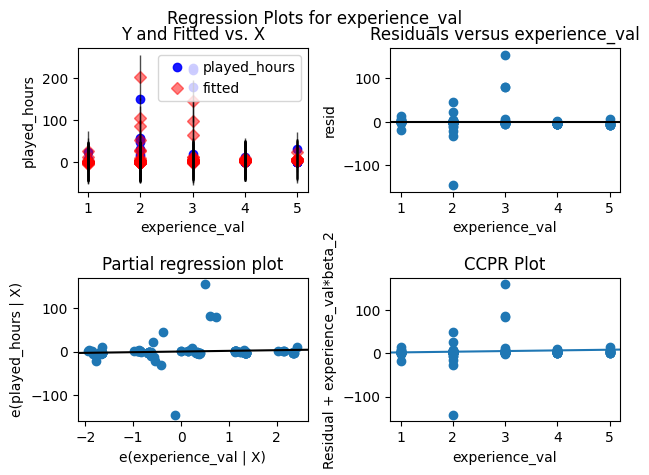

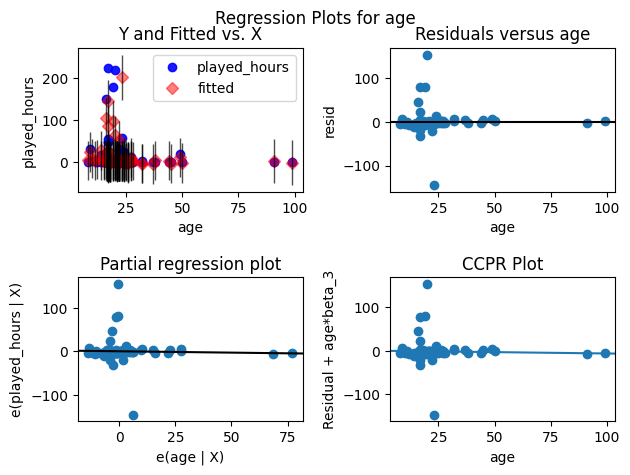

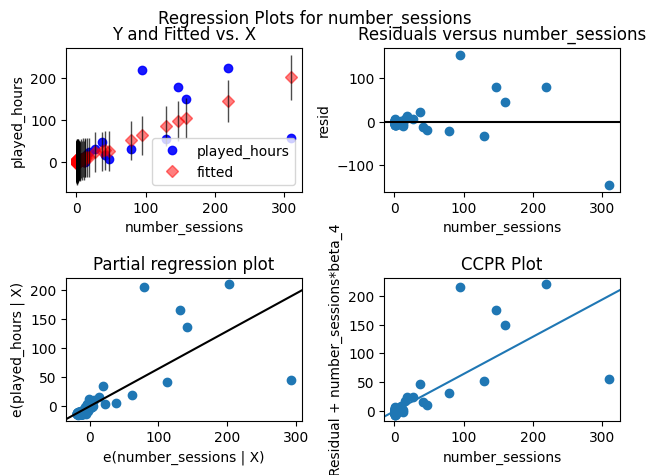

In [17]:
sm.graphics.plot_regress_exog(reg_1,"experience_val")
plt.show()

sm.graphics.plot_regress_exog(reg_1,"age")
plt.show()

sm.graphics.plot_regress_exog(reg_1,"number_sessions")
plt.show()

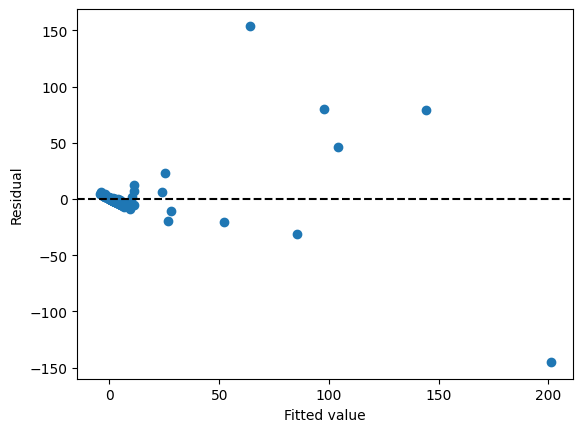

In [18]:
fitted_y = reg_1.fittedvalues

residuals = reg_1.resid

plt.scatter(fitted_y,residuals)
plt.axhline(y = 0, color = 'k', linestyle = '--')
plt.xlabel('Fitted value')
plt.ylabel('Residual')
plt.show()

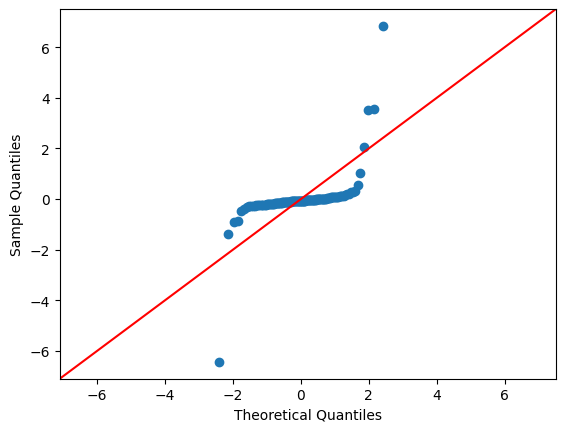

In [19]:
residuals = reg_1.resid

sm.qqplot(residuals,fit=True, line="45")
plt.show()